# Analyze STRF Parameters #
### Written by Kushal Bakshi and Ethan Vega for Dr. Mike Smotherman's Lab at Texas A&M University ###

## Objective: Quantify differences in parameters of different types of STRFs ##

> The notebook imports parameters of spectrotemporal receptive fields obtained from microelectrode array recordings from the primary auditory cortex (A1) of Mexican Free-Tailed Bats. Data indicates 4 categories of STRF are presented in the bat A1. The goal of this notebook is to quantify differences among single and multipeak STRFs before analyzing each of the 4 categories in more detail.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import shapiro, levene
import statsmodels.api as sm
import seaborn as sns
from scipy.io import loadmat

In [2]:
def load_strf_summary(strfFilepath, peakFilepath):
    summary = loadmat(strfFilepath, squeeze_me = True)
    paramDF = pd.DataFrame(summary['strf_table'], columns = summary['strf_table'][0])
    paramDF = paramDF.drop(index = 0).reset_index()
    paramDF.drop(labels = 'index', axis = 1, inplace = True)
    paramDF['Peaks'] = pd.read_excel(peakFilepath, header=0, sheet_name='Spike Sorting', usecols='E')
    paramDF['Type'] = pd.read_excel(peakFilepath, header=0, sheet_name='Spike Sorting', usecols='F')
    return paramDF

In [3]:
def plotResiduals(fitted_values, residuals):
    fig, ax1 = plt.subplots(figsize=(10, 7))
    sns.regplot(fitted_values, residuals, ax=ax1)
    ax1.set_title('Residuals Plot')
    ax1.set_xlabel('Fitted Values')
    ax1.set_ylabel('Residuals')
    plt.show()

In [4]:
#logit_mod Function

def logit(predictors, modelDF):
    logit_mod = sm.Logit(modelDF['Peaks'].astype(int), modelDF[predictors]).fit()
    print('logit_mod AIC = ', logit_mod.aic)
    print(logit_mod.summary())
    return logit_mod

In [5]:
strf_summary = load_strf_summary(strfFilepath='C:/Users/kbakshi/Documents/Data/STRF Analysis/sorted_STRFs_032522.mat', peakFilepath='C:/Users/kbakshi/Documents/Data/STRF Analysis/STRF Summary.xlsx')
strf_summary['Peaks']= strf_summary['Peaks'].apply(lambda x: '0' if (x > 1) else '1')
col_list = list(strf_summary.columns)
for column in range(2, len(col_list)-2):
    strf_summary[col_list[column]] = strf_summary[col_list[column]].astype('float64')

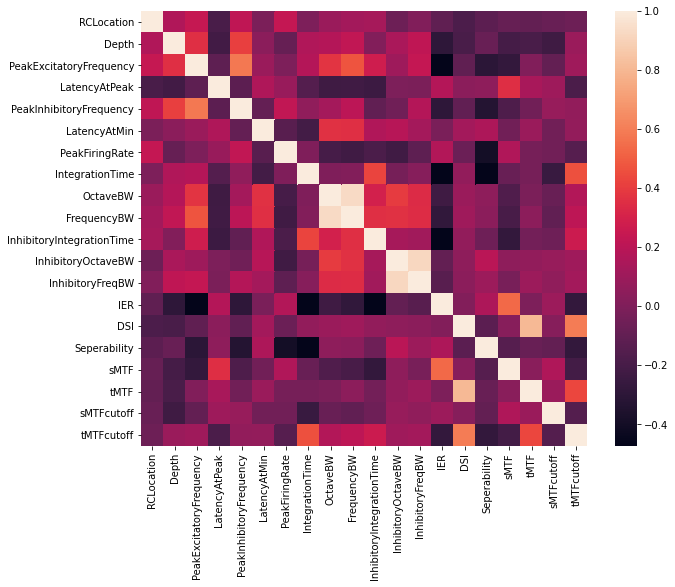

In [6]:
# Find correlations among predictors
plt.figure(figsize=(10,8))
sns.heatmap(strf_summary.corr())
plt.show()

In [7]:
# Drop one of the highly correlated variables
strf_summary.drop(columns={'InhibitoryOctaveBW', 'OctaveBW'}, inplace=True)
col_list = list(strf_summary.columns)

In [8]:
# Split by single/multi peak STRF
multi_peak = strf_summary[strf_summary['Peaks'] == '0']
one_peak = strf_summary[strf_summary['Peaks'] == '1']

In [9]:
#Test for normality
for column in range(4, len(col_list)-2):
    print(col_list[column] + ':')
    print(shapiro(one_peak[col_list[column]]))

PeakExcitatoryFrequency:
ShapiroResult(statistic=0.9205659627914429, pvalue=0.0002790087310131639)
LatencyAtPeak:
ShapiroResult(statistic=0.9187802672386169, pvalue=0.00023299096210394055)
PeakInhibitoryFrequency:
ShapiroResult(statistic=nan, pvalue=1.0)
LatencyAtMin:
ShapiroResult(statistic=nan, pvalue=1.0)
PeakFiringRate:
ShapiroResult(statistic=0.8800528645515442, pvalue=6.886360097269062e-06)
IntegrationTime:
ShapiroResult(statistic=0.9908440113067627, pvalue=0.8938146233558655)
FrequencyBW:
ShapiroResult(statistic=0.6687551736831665, pvalue=2.7552087347726406e-11)
InhibitoryIntegrationTime:
ShapiroResult(statistic=nan, pvalue=1.0)
InhibitoryFreqBW:
ShapiroResult(statistic=nan, pvalue=1.0)
IER:
ShapiroResult(statistic=0.9273277521133423, pvalue=0.00056145538110286)
DSI:
ShapiroResult(statistic=0.9517545700073242, pvalue=0.008968456648290157)
Seperability:
ShapiroResult(statistic=0.8686931729316711, pvalue=2.7568717086978722e-06)
sMTF:
ShapiroResult(statistic=0.717376172542572, pval

In [10]:
# Test for heteroscedasticity. Levene's test in cases where samples are highly non-normal

for column in range(4, len(col_list)-2):
    _, p = levene(one_peak[col_list[column]], multi_peak[col_list[column]], center='median')
    print(col_list[column] + ': ' + str(p))

PeakExcitatoryFrequency: 0.6881074214003853
LatencyAtPeak: 0.022513823607154232
PeakInhibitoryFrequency: nan
LatencyAtMin: nan
PeakFiringRate: 0.3803214456887949
IntegrationTime: 0.7504575013842332
FrequencyBW: 0.4881892577699479
InhibitoryIntegrationTime: nan
InhibitoryFreqBW: nan
IER: 0.7270721095903818
DSI: 0.628971963202942
Seperability: 0.866287663681288
sMTF: 0.6683309702628515
tMTF: 0.14181463319683255
sMTFcutoff: 0.24358009511666542
tMTFcutoff: 0.2997252745472267


Above results indicate dissimilar (non-equal) variances

In [ ]:
model_1 = logit(predictors=col_names, modelDF=strf_summary)

In [ ]:
model_2 = logit(predictors = ['DSI', 'tMTFcutoff', 'IntegrationTime'], modelDF=strf_summary)

In [ ]:
plotResiduals(model_1.fittedvalues, model_1.resid_dev)

In [ ]:
#2 Sample T-Test (for now?) for Seperability and Average Direction Selectivity

seperability_1 = strf_summary.loc[(strf_summary['Peaks'] == 1)]
seperability_2 = strf_summary.loc[(strf_summary['Peaks'] == 2)]

#stats.ttest_ind(a=seperability_1, b=seperability_2, equal_var=True)

In [ ]:
#Models

#One Peak
strf_one = strf_summary[strf_summary['Peaks'] == 1]
emo = strf_one['PeakExcitatoryFrequency'].mean()
imo = strf_one['PeakInhibitoryFrequency'].mean()
print(emo, imo)

#Two Peak
strf_two = strf_summary[strf_summary['Peaks'] == 2]
emt = strf_two['PeakExcitatoryFrequency'].mean()
imt = strf_two['PeakInhibitoryFrequency'].mean()
print(emt, imt)

#Bar Graph for PEF and PIM

X = ['Peak Excitatory Frequency','Peak Inhibitory Frequency']
onepeak = [43.8147490175195, 38.2506299015672]
twopeak = [48.11933407373453, 44.98541848424552]
  
X_axis = np.arange(len(X))
Y_axis = 70
  
plt.bar(X_axis - 0.1, onepeak, 0.2, label = '1 Peak', color = 'green')
plt.bar(X_axis + 0.1, twopeak, 0.2, label = '2 Peaks', color = 'navy')

plt.xticks(X_axis, X)
plt.xlabel("...")
plt.ylabel("Frequency (kHz)")
plt.title("...")
plt.legend()
plt.show()

In [ ]:
#Bar Graph for SMTF

emo = strf_one['sMTF'].mean()
imo = strf_one['tMTF'].mean()
print(emo, imo)

strf_two = strf_summary[strf_summary['Peaks'] == 2]
emt = strf_two['sMTF'].mean()
imt = strf_two['tMTF'].mean()
print(emt, imt)